In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SEED = 666
DATA_FILE = '../Datasets/cats/data/breeds_data_final.pkl'
IMAGES_DIR = '../Datasets/cats/images'
FIGURES_DIR = '../Figures/'
RESOLUTION = 64
LEARNING_RATE = 0.01

In [3]:
data = pd.read_pickle(DATA_FILE)
# PROBLEM: 26 unique breeds, but 66 included in final number of breeds, 
# lots of inaccuracy to account for here
len(data['breed'].unique())

26

In [4]:
# Cats data string convertor
# Data was collected from Analysis/cats/cats_prediction_2.ipynb
age_list = ['Adult', 'Baby', 'Senior', 'Young']
gender_list = ['Female', 'Male']
size_list = ['Extra Large', 'Large', 'Medium', 'Small']
coat_list = ['Hairless', 'Long', 'Medium', 'Short']
full_breed_list = ['Abyssinian', 'American Bobtail', 'American Curl',
        'American Shorthair', 'American Wirehair', 'Applehead Siamese',
        'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair',
        'Burmese', 'Burmilla', 'Calico', 'Canadian Hairless', 'Chartreux',
        'Chausie', 'Chinchilla', 'Cornish Rex', 'Cymric', 'Devon Rex',
        'Dilute Calico', 'Dilute Tortoiseshell', 'Domestic Long Hair',
        'Domestic Medium Hair', 'Domestic Short Hair', 'Egyptian Mau',
        'Exotic Shorthair', 'Extra-Toes Cat - Hemingway Polydactyl',
        'Havana', 'Himalayan', 'Japanese Bobtail', 'Javanese', 'Korat',
        'LaPerm', 'Maine Coon', 'Manx', 'Munchkin', 'Nebelung',
        'Norwegian Forest Cat', 'Ocicat', 'Oriental Long Hair',
        'Oriental Short Hair', 'Oriental Tabby', 'Persian', 'Pixiebob',
        'Ragamuffin', 'Ragdoll', 'Russian Blue', 'Scottish Fold',
        'Selkirk Rex', 'Siamese', 'Siberian', 'Silver', 'Singapura',
        'Snowshoe', 'Somali', 'Sphynx - Hairless Cat', 'Tabby', 'Tiger',
        'Tonkinese', 'Torbie', 'Tortoiseshell', 'Turkish Angora',
        'Turkish Van', 'Tuxedo', 'York Chocolate']

breed_list = np.empty(len(full_breed_list),dtype=object)
for i in range(len(full_breed_list)):
    if (i+1 in data['breed'].unique()):
        breed_list[i] = full_breed_list[i]

breed_list = breed_list[breed_list != None]
print(breed_list)

def get_cat_string(cat, value):
    if(cat == 'age'):
        return age_list[int(value)]
    elif(cat == 'gender'):
        return gender_list[int(value)]
    elif(cat == 'size'):
        return size_list[int(value)]
    elif(cat == 'coat'):
        return coat_list[int(value)]
    elif(cat == 'breed'):
        return breed_list[int(value)]

['Abyssinian' 'American Curl' 'Balinese' 'Birman' 'Burmilla' 'Devon Rex'
 'Dilute Calico' 'Dilute Tortoiseshell' 'Domestic Long Hair'
 'Domestic Medium Hair' 'Exotic Shorthair' 'Havana' 'LaPerm' 'Maine Coon'
 'Oriental Tabby' 'Ragamuffin' 'Ragdoll' 'Selkirk Rex' 'Singapura'
 'Sphynx - Hairless Cat' 'Tabby' 'Tonkinese' 'Torbie' 'Tortoiseshell'
 'Turkish Angora' 'Turkish Van']


# Prepare Data

In [5]:
# Images
import cv2
import random

random.seed(SEED)

In [6]:
def load_images(df):
    images = []
    for path in df['image']:
        img = cv2.resize(cv2.imread(os.path.join(IMAGES_DIR, path), cv2.COLOR_BGR2RGB), (RESOLUTION, RESOLUTION), interpolation=cv2.INTER_CUBIC)            # Read and resize
        if(img is None):
            raise Exception('Error reading path', path)
        images.append(img.astype(np.float32) / 255.0)        # Normalize data to range [0,1])
    return np.array(images)

In [7]:
images = load_images(data)

In [8]:
print(len(data.iloc[:, 4]))
print(images.shape)

37794
(37794, 64, 64, 3)


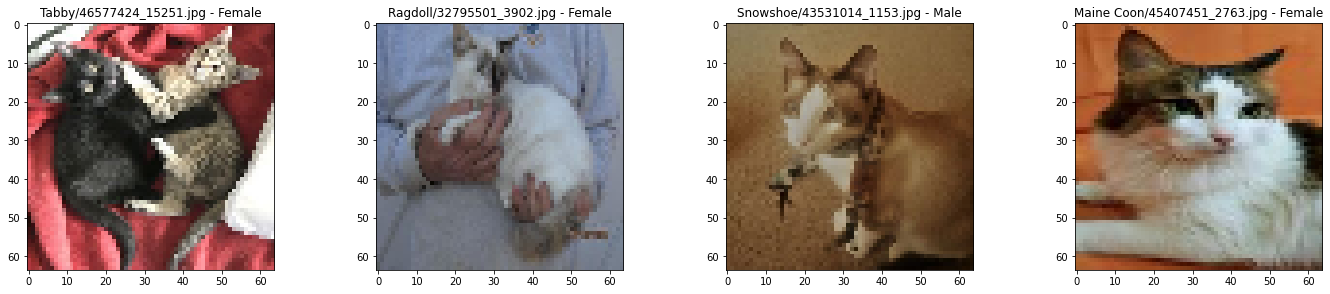

In [9]:
# I'm doubting if ML can determine a cat's gender... will test it using CNN
fig = plt.figure(figsize=(24, 10))
for i, r in enumerate([random.randint(0, images.shape[0]) for _ in range(4)]):
    ax = plt.subplot(2, 4, i + 1)
    ax.set_title(data.iloc[r, 5] + ' - ' + get_cat_string('gender', data.iloc[r, 1]))
    ax.imshow(cv2.cvtColor(images[r], cv2.COLOR_BGR2RGB))

# Network 1 - Basic CNN

In [10]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# Breeds - [:, 4] are labels, images are X
train_X, val_X, train_y, val_y = train_test_split(images, data.iloc[:, 4], random_state = SEED, test_size=0.2)
print(len(pd.unique(train_y)))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

26
(30235, 64, 64, 3) (30235,) (7559, 64, 64, 3) (7559,)


In [12]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(RESOLUTION, RESOLUTION, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(512, activation='relu'))
model_1.add(layers.Dense(66, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         1

In [16]:

to_categorical(train_y)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
batch = 32
epochs = 15
opt = optimizers.RMSprop(momentum=0.9)

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_1 = model_1.fit(train_X, to_categorical(train_y), 
                        epochs=epochs, validation_data=(val_X, to_categorical(val_y)))

IndexError: index 44 is out of bounds for axis 1 with size 26

In [ ]:
# inaccurate
#model_1.evaluate(val_X, to_categorical(val_y))

In [ ]:
import pickle

with open('../History/basic_CNN_epochs_'+str(epochs), 'wb') as file_pi:
        pickle.dump(history_1.history, file_pi)

In [ ]:
# Predict the values from the validation dataset
y_pred = model_1.predict(val_X)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#print(to_categorical(train_y).shape)
y_true = np.argmax(to_categorical(val_y, num_classes=len(breed_list)),axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

In [ ]:
# print single prediction
# print(y_pred[0])
# plt.imshow(val_x[0])

In [ ]:
p = FIGURES_DIR+'basic_CNN/'
if not os.path.exists(p.rsplit('/',1)[0]):
    os.makedirs(p.rsplit('/',1)[0])

plt.plot(history_1.history['accuracy'], label='training data')
plt.plot(history_1.history['val_accuracy'], label='validation data')
t = 'Accuracy with '+str(epochs)+' Epochs'
plt.title(t)
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
name = p+'model_Accuracy_'+str(epochs)+'Epochs.png'
plt.savefig(name)
plt.show()

In [ ]:
import seaborn as sns
print(len(pd.unique(y_pred_classes)))

print(confusion_mtx)

br = pd.unique(y_pred_classes)

plt.figure(figsize=(20, 20))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
#c.set(xticklabels=br, yticklabels=br)
plt.savefig(p+'Basic_CNN_heatmap.png')

# Network 2 - Combine Net